### Sentiment Classification of IMDB Reviews

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.8.0
Num GPUs Available:  1
Num CPUs Available:  1


## 1. Text Classification

### (a) Data Exploration and Pre-processing
#### Use binary encoding for the sentiments , y = 1 for positive sentiments and y = −1 for negative sentiments.

- Note: we are using y = 1 for pos and y = 0 for neg instead, cuz Sigmoid is used a lot.

In [3]:
raw_train = keras.preprocessing.text_dataset_from_directory(
    "data/train",
    labels="inferred",
    label_mode="binary",
    batch_size=None,
    validation_split=None,
    #shuffle=False,
    class_names=["neg_train","pos_train"]
)
raw_test = keras.preprocessing.text_dataset_from_directory(
    "data/test",
    labels="inferred",
    label_mode="binary",
    batch_size=None,
    validation_split=None,
    #shuffle=False,
    class_names=["neg_test","pos_test"]
)

Found 1400 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


#### Remove the punctuation and numbers from the data.
- Realized by RegEx replace (string methods of tf)

#### Use text files 0-699 in each class for training and 700-999 for testing.

In [5]:
def regex(text):
    tmp = tf.strings.strip(tf.strings.regex_replace(tf.strings.regex_replace(text,'[[:^alpha:]]', ' '),' +', ' '))
    return tmp

raw_train_list = list(raw_train)
raw_test_list = list(raw_test)

#tensor list
train_X_list = list(map(lambda x: regex(x[0]), raw_train_list))
train_y_list = list(map(lambda x: x[1], raw_train_list))
test_X_list = list(map(lambda x: regex(x[0]), raw_test_list))
test_y_list = list(map(lambda x: x[1], raw_test_list))

#pure utf-8 text list
train_X = [d.numpy().decode('utf-8') for d in train_X_list]
test_X = [d.numpy().decode('utf-8') for d in test_X_list]

#numpy array targets
train_y = np.array(train_y_list)
test_y = np.array(test_y_list)

print("sample output after regex:\n", train_X[717])

sample output after regex:
 every year every year at the festival i wait for that film to come along that one that just pulls me out of my seat sticks its face up next to my nose and roars sur prise into my bewildered visage it s almost always a surprise it sure as niflheim was this time amazing grace and chuck is being advertised as a modern fairy tale of a boy in montana who quits his little league team for a very unusual reason and in the hands of anyone less careful than the creative staff of this film it might very well be nothing more than a fairy tale where we roll our eyes occasionally smirk to ourselves and maybe get a forced tear out of the eyes and a boy i wish that could happen sigh out of the lips upon exiting the theater and tossing the empty pepsi cup into the trash another e t another short circuit this film floored me for the simple reason that while it has a fairy tale concept the rest of the film takes itself seriously enough and presents itself well enough to make i

#### Count the number of unique words in the whole dataset (train + test)

In [6]:
def unique_word_count(dataset):
    t = keras.preprocessing.text.Tokenizer()
    t.fit_on_texts(dataset)
    print("    number of unique words:", len(t.word_counts))
    print("    number of words (length):", sum(t.word_counts.values()))

print("train set alone:")
unique_word_count(train_X)
print("test set alone:")
unique_word_count(test_X)
print("train + test:")
unique_word_count(train_X + test_X)

train set alone:
    number of unique words: 33688
    number of words (length): 927742
test set alone:
    number of unique words: 23687
    number of words (length): 403530
train + test:
    number of unique words: 38911
    number of words (length): 1331272


#### Calculate the average review length and the standard deviation of review lengths. 

#### Plot the histogram of review lengths.

train set alone:
    average review length: 662.6728571428572
    std of review lengths: 293.8986124603559


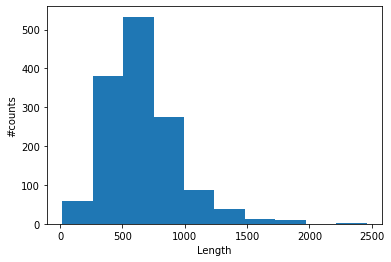

test set alone:
    average review length: 672.55
    std of review lengths: 292.98901145492357


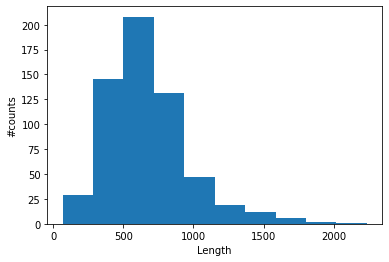

train + test:
    average review length: 665.636
    std of review lengths: 293.66091245516486


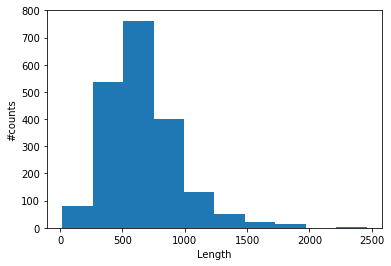

In [7]:
def get_len_list(dataset):
    len_list = []
    for text in dataset:
        t = keras.preprocessing.text.Tokenizer()
        t.fit_on_texts([text])
        len_list.append(sum(t.word_counts.values()))
    mean_std(len_list)
    len_hist(len_list)
    return len_list

def mean_std(len_list):
    mean = np.mean(len_list)
    std = np.std(len_list)
    print("    average review length:", mean)
    print("    std of review lengths:", std)
    
def len_hist(len_list):
    plt.hist(len_list)
    plt.xlabel("Length")
    plt.ylabel("#counts")
    plt.show()

print("train set alone:")
train_len_list = get_len_list(train_X)
print("test set alone:")
test_len_list = get_len_list(test_X)
print("train + test:")
whole_len_list = get_len_list(train_X + test_X)

#### Tokenization.
- Note: EACH text sample is tokernized separately here, they each formed a dictionary of their own vocabulary. 
- However, to fit the model we'll need a dictionary of the whole training set, see different implementation in function get_sequences( )

In [8]:
def get_popularity(dataset):
    word_index_list = []
    for text in dataset:
        t = keras.preprocessing.text.Tokenizer()
        t.fit_on_texts([text])
        #print(sorted(t.word_counts.values()))
        #print(t.word_index)
        word_index_list.append(t.word_index)
    return word_index_list
    
print("tokenizing train set...")
train_ranks_list = get_popularity(train_X)
print("  sample output:\n", train_ranks_list[615])
print("\ntockenizing test set...")
test_ranks_list = get_popularity(test_X)
print("  sample output:\n", test_ranks_list[13])
#print("tokenizing train + test ...")
#train_ranks_list = get_popularity(train_X+test_X)
#print("-- freq rank list:", train_ranks_list)

tokenizing train set...
  sample output:
 {'a': 1, 'the': 2, 'of': 3, 'to': 4, 'in': 5, 'dance': 6, 'it': 7, 'shall': 8, 'we': 9, 'and': 10, 'with': 11, 's': 12, 'sugiyama': 13, 'is': 14, 'his': 15, 'as': 16, 'story': 17, 'up': 18, 'suo': 19, 'which': 20, 'be': 21, 'its': 22, 'he': 23, 'school': 24, 'her': 25, 'that': 26, 'rather': 27, 'an': 28, 'you': 29, 't': 30, 'japanese': 31, 'koji': 32, 'yakusho': 33, 'one': 34, 'when': 35, 'mai': 36, 'by': 37, 'for': 38, 'dancing': 39, 'wife': 40, 'becomes': 41, 'on': 42, 'hollywood': 43, 'film': 44, 'can': 45, 'into': 46, 'comedy': 47, 'matter': 48, 'than': 49, 'does': 50, 'some': 51, 'new': 52, 'personalities': 53, 'most': 54, 'small': 55, 'steps': 56, 'feel': 57, 'good': 58, 'formulaic': 59, 'may': 60, 'own': 61, 'way': 62, 'also': 63, 'demonstrates': 64, 'kind': 65, 'charming': 66, 'restraint': 67, 'don': 68, 'often': 69, 'find': 70, 'american': 71, 'films': 72, 'this': 73, 'import': 74, 'tells': 75, 'middle': 76, 'aged': 77, 'accountant': 7

#### Select a review length L:  70% and 90% of the reviews have a length below it.

In [9]:
def decide_l(len_list, q):
    return np.percentile(len_list, q)
    
L_70 = int(decide_l(train_len_list,70))
print("70% L =", L_70)
L_90 = int(decide_l(train_len_list,90))
print("90% L =", L_90)

70% L = 753
90% L = 1018


#### Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L.

In [13]:
def get_sequences(dataset):
    t = keras.preprocessing.text.Tokenizer()
    t.fit_on_texts(dataset[:1400]) #only fit on train
    return t.texts_to_sequences(dataset)

def truncating_n_padding(dataset, l):
    sequences = get_sequences(dataset)
    return keras.preprocessing.sequence.pad_sequences(sequences, truncating='pre', padding='post', maxlen=l)

#truncating = 'post'
#padding = 'post'

padded_70 = truncating_n_padding(train_X+test_X, L_70)
padded_90 = truncating_n_padding(train_X+test_X, L_90)
print("-- 70% L --")
print("shape of output:", padded_70.shape)
print("-- 90% L --")
print("shape of output:", padded_90.shape)

train_padded_70 = padded_70[:1400]
#print(train_padded_70.shape)
test_padded_70 = padded_70[1400:]
#print(test_padded_70.shape)

train_padded_90 = padded_90[:1400]
test_padded_90 = padded_90[1400:]

print("\n  sample output:\n", padded_70[1212])

-- 70% L --
shape of output: (2000, 753)
-- 90% L --
shape of output: (2000, 1018)

  sample output:
 [ 5115     6     2  2515   476     4    46    54   601    47    30   489
     5  5656     2    25   949  1283     2   259    89   232   117  8358
 12944     6    60  2959     5    16   247  4168   801   145     5   121
 18954    11     1  2976 11821  4949  5670   349    11  4643  4436     2
  1006  6243 12306    13     2  8439   272    31     2  4158 19120   143
    18  1521     1 11153     4    14  1889  5838   831 31854   375 11513
     7     1  7545   516     4   161    18    54  1671     7    14  2253
    26  8930  1827 31855    23     2 31856     3    65     4    38     2
  2399   218     5   135    58    45     7   193  4643    36     5   141
    31   503  2666   322     5    87   511   588    19    39   160    24
     2   688    31     1   131     4    10  4209    18  2129    45    11
     2   344  7491  2121     7     2 31857  4274   403    23     1  3508
     8   668 31858  21

### (b) Word Embeddings
#### We are interested in the top 5,000 words and 7,000 words.
- This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000/7,000 words in the document. 

In [15]:
def embedding(padded_text, top_words):
    model = keras.Sequential()
    model.add(layers.Embedding(top_words, 32))
    model.compile('rmsprop', 'mse')
    output_array = model.predict(padded_text)
    print("shape of output:", output_array.shape)
    return output_array

print("-- 70% L --")
embedded_70 = embedding(padded_70, 5000)
print("-- 90% L --")
embedded_90 = embedding(padded_90, 5000)

print("\n  sample output:\n", embedded_70[502])

-- 70% L --
shape of output: (2000, 753, 32)
-- 90% L --
shape of output: (2000, 1018, 32)

  sample output:
 [[-0.00756687 -0.04414221  0.0088793  ...  0.00858375  0.03821745
  -0.0171473 ]
 [-0.02984439  0.01097547  0.02475737 ...  0.03875841 -0.00260548
  -0.03710032]
 [-0.03138181  0.04057566  0.04692687 ... -0.0238717  -0.01298435
  -0.02215447]
 ...
 [ 0.01682469 -0.03046727 -0.01494098 ...  0.03729475  0.04902737
  -0.03780967]
 [-0.00019054  0.00159942  0.0235624  ...  0.03436607 -0.01965669
   0.03088603]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


#### Flatten the matrix of each document to a vector.
- the whole implementation of (c)i & (c)ii

In [18]:
def embedding_n_flattening(padded_text, top_words):
    model = keras.Sequential()
    model.add(layers.Embedding(top_words, 32))
    model.add(layers.Flatten())
    model.compile('rmsprop', 'mse')
    output_array = model.predict(padded_text)
    print("shape of output:", output_array.shape)
    return output_array

print("-- 70% L --")
embedded_flatten_70 = embedding_n_flattening(padded_70, 5000)
print("-- 90% L --")
embedded_flatten_90 = embedding_n_flattening(padded_90, 5000)

print("\n  sample output:\n", embedded_flatten_70[502])

-- 70% L --
shape of output: (2000, 24096)
-- 90% L --
shape of output: (2000, 32576)

  sample output:
 [-0.00756687 -0.04414221  0.0088793  ...  0.          0.
  0.        ]


### (c) Multi-Layer Perceptron
#### Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, set the number of epochs as 2. Use a batch size of 10.
- for both 70%L and 90%L, epoch = 2 yielded their best results with a accuracy of about 60%-70%.

In [20]:
def create_mlp(l):
    model = keras.models.Sequential([
        layers.Input(shape=(l,)),
        layers.Embedding(5000, 32),
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.summary()
    return model

def fit_train_mlp(train_X, train_y, l, epoch):
    print("training start...")
    model = create_mlp(l)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                   metrics=['binary_accuracy'])
    model.fit(train_X, train_y, batch_size=10, epochs=epoch)
    return model
    
print("-- 70% L --")
mlp_70 = fit_train_mlp(train_padded_70, train_y, L_70, 2)
print("\n  -- train set accuracy --")
mlp_70.evaluate(train_padded_70, train_y, batch_size=10)
print("  -- test set accuracy --")
mlp_70.evaluate(test_padded_70, test_y, batch_size=10)
print("\n-- 90% L --")
mlp_90 = fit_train_mlp(train_padded_90, train_y, L_90, 2)
print("\n  -- train set accuracy --")
mlp_90.evaluate(train_padded_90, train_y, batch_size=10)
print("  -- test set accuracy --")
mlp_90.evaluate(test_padded_90, test_y, batch_size=10)

-- 70% L --
training start...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 753, 32)           160000    
                                                                 
 flatten_8 (Flatten)         (None, 24096)             0         
                                                                 
 dense_8 (Dense)             (None, 50)                1204850   
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)      

[0.6081604957580566, 0.6483333706855774]

### (d) One-Dimensional Convolutional Neural Network
#### Although CNNs are mainly used for image data, they can also be applied to text data, as text also has adjacency information. Keras supports one-dimensional convolutions and pooling by the Conv1D and MaxPooling1D classes respectively.
#### After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.
- epoch = 3 seemed to work better with this CNN setting. accuracies of 70-80%.

In [21]:
def create_cnn(l):
    model = keras.models.Sequential([
        layers.Input(shape=(l,)),
        layers.Embedding(5000, 32),
        layers.Conv1D(32, 3, activation='relu'),
        layers.MaxPooling1D(pool_size=16, strides=2),
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.summary()
    return model

def fit_train_cnn(train_X, train_y, l, epoch):
    print("training start...")
    model = create_cnn(l)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                   metrics=['binary_accuracy'])
    model.fit(train_X, train_y, batch_size=10, epochs=epoch)
    return model
    
print("-- 70% L --")
cnn_70 = fit_train_cnn(train_padded_70, train_y, L_70, 3)
print("\n  -- train set accuracy --")
cnn_70.evaluate(train_padded_70, train_y, batch_size=10)
print("  -- test set accuracy --")
cnn_70.evaluate(test_padded_70, test_y, batch_size=10)
print("\n-- 90% L --")
cnn_90 = fit_train_cnn(train_padded_90, train_y, L_90, 3)
print("\n  -- train set accuracy --")
cnn_90.evaluate(train_padded_90, train_y, batch_size=10)
print("  -- test set accuracy --")
cnn_90.evaluate(test_padded_90, test_y, batch_size=10)

-- 70% L --
training start...
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 753, 32)           160000    
                                                                 
 conv1d (Conv1D)             (None, 751, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 368, 32)          0         
 )                                                               
                                                                 
 flatten_10 (Flatten)        (None, 11776)             0         
                                                                 
 dense_16 (Dense)            (None, 50)                588850    
                                                                 
 dropout_12 (Dropout)        (None, 50)                0         
                       

[0.4784056842327118, 0.7850000262260437]

### (e) Long Short-Term Memory Recurrent Neural Network
####  Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.

Summary:
- try 1: LSTM units = 256, best accuracy = 58% when epoch = 44 (epoch range 10-50)
- try 2: LSTM units = 32, best accuracy = 61% when epoch = 23 (epoch range 10-50)
- try 3: top_words = 20,000, accuracy = 55% (epoch = 10)
- try 4: top_words = #unique_words, accuracy = 60% (epoch = 10)
- try 5: remove stopwords, best accuracy = 57% when epoch = 15 (epoch set to 15 & 25)
- try 6: slower learning rate = 0.0001, best accuracy = 76% when epoch = 8 (epoch set to 8 & 12)
- try 7: BRNN , best accuracy = 78% when epoch = 12 (epoch set to 7 & 12-24)

Adjustments that brought improvement:
- Bigger Vocabulary 
- Stopwords Removal
- Slower Learning Rate
- BRNN

-- try 1: LSTM layer units set to 256 --
- accuracy didn't increase between epochs, and test accu didn't hit 60% eventually (epoch range 10-50)
- The model basically learned nothing.

In [39]:
def create_lstm(l):
    model = keras.models.Sequential([
        layers.Input(shape=(l,)),
        layers.Embedding(5000, 32),
        layers.LSTM(256),
        layers.Dropout(0.2),
        #layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.summary()
    return model

def fit_train_lstm(train_X, train_y, test_X, test_y, l, epoch):
    print("training start... epochs =", epoch)
    model = create_lstm(l)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                   metrics=['binary_accuracy'])
    model.fit(train_X, train_y, batch_size=10, epochs=epoch, validation_split=0.2)
    print("evaluating...")
    train_res = model.evaluate(train_X, train_y, batch_size=10)
    test_res = model.evaluate(test_X, test_y, batch_size=10)
    return [train_res[1],test_res[1]]

In [40]:
print("-- 70% L --")
train_acc = []
test_acc = []
for epoch in range(10, 51):
    res_lstm_70 = fit_train_lstm(train_padded_70, train_y, test_padded_70, test_y, L_70, epoch)
    train_acc.append(res_lstm_70[0])
    test_acc.append(res_lstm_70[1])


-- 70% L --
training start... epochs = 10
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 759, 32)           160000    
                                                                 
 lstm_13 (LSTM)              (None, 256)               295936    
                                                                 
 dropout_44 (Dropout)        (None, 256)               0         
                                                                 
 dense_50 (Dense)            (None, 256)               65792     
                                                                 
 dropout_45 (Dropout)        (None, 256)               0         
                                                                 
 dense_51 (Dense)            (None, 1)                 257       
                                                                 
Total param

112/112 [==============================] - 23s 201ms/step - loss: 0.5225 - binary_accuracy: 0.6527 - val_loss: 0.9882 - val_binary_accuracy: 0.5286
Epoch 14/14
112/112 [==============================] - 22s 201ms/step - loss: 0.5359 - binary_accuracy: 0.6545 - val_loss: 0.6913 - val_binary_accuracy: 0.5107
evaluating...
60/60 [==============================] - 6s 105ms/step - loss: 0.6905 - binary_accuracy: 0.5233
training start... epochs = 15
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 759, 32)           160000    
                                                                 
 lstm_18 (LSTM)              (None, 256)               295936    
                                                                 
 dropout_54 (Dropout)        (None, 256)               0         
                                                                 
 

112/112 [==============================] - 23s 208ms/step - loss: 0.4760 - binary_accuracy: 0.6804 - val_loss: 1.1398 - val_binary_accuracy: 0.5179
Epoch 18/18
112/112 [==============================] - 23s 207ms/step - loss: 0.4847 - binary_accuracy: 0.6839 - val_loss: 1.0598 - val_binary_accuracy: 0.5214
evaluating...
60/60 [==============================] - 6s 108ms/step - loss: 1.0929 - binary_accuracy: 0.5600
training start... epochs = 19
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 759, 32)           160000    
                                                                 
 lstm_22 (LSTM)              (None, 256)               295936    
                                                                 
 dropout_62 (Dropout)        (None, 256)               0         
                                                                 
 

112/112 [==============================] - 23s 210ms/step - loss: 0.6874 - binary_accuracy: 0.6402 - val_loss: 0.7359 - val_binary_accuracy: 0.5250
Epoch 6/22
112/112 [==============================] - 24s 211ms/step - loss: 0.5162 - binary_accuracy: 0.6750 - val_loss: 0.8167 - val_binary_accuracy: 0.5107
Epoch 7/22
112/112 [==============================] - 24s 211ms/step - loss: 0.4921 - binary_accuracy: 0.6732 - val_loss: 0.9184 - val_binary_accuracy: 0.5000
Epoch 8/22
112/112 [==============================] - 23s 210ms/step - loss: 0.4888 - binary_accuracy: 0.6759 - val_loss: 0.9060 - val_binary_accuracy: 0.5143
Epoch 9/22
112/112 [==============================] - 24s 210ms/step - loss: 0.4880 - binary_accuracy: 0.6732 - val_loss: 1.0421 - val_binary_accuracy: 0.5250
Epoch 10/22
112/112 [==============================] - 24s 210ms/step - loss: 0.4908 - binary_accuracy: 0.6795 - val_loss: 1.0362 - val_binary_accuracy: 0.5357
Epoch 11/22
112/112 [==============================] - 2

Epoch 11/25
112/112 [==============================] - 24s 214ms/step - loss: 0.4881 - binary_accuracy: 0.6759 - val_loss: 1.0915 - val_binary_accuracy: 0.5000
Epoch 12/25
112/112 [==============================] - 24s 213ms/step - loss: 0.4838 - binary_accuracy: 0.6821 - val_loss: 0.8932 - val_binary_accuracy: 0.5393
Epoch 13/25
112/112 [==============================] - 24s 212ms/step - loss: 0.4857 - binary_accuracy: 0.6768 - val_loss: 1.3502 - val_binary_accuracy: 0.4964
Epoch 14/25
112/112 [==============================] - 24s 213ms/step - loss: 0.4903 - binary_accuracy: 0.6804 - val_loss: 0.8524 - val_binary_accuracy: 0.5321
Epoch 15/25
112/112 [==============================] - 24s 213ms/step - loss: 0.4884 - binary_accuracy: 0.6661 - val_loss: 1.0521 - val_binary_accuracy: 0.4893
Epoch 16/25
112/112 [==============================] - 24s 212ms/step - loss: 0.4834 - binary_accuracy: 0.6821 - val_loss: 1.3956 - val_binary_accuracy: 0.4964
Epoch 17/25
112/112 [===================

Epoch 8/28
112/112 [==============================] - 25s 221ms/step - loss: 0.4909 - binary_accuracy: 0.6723 - val_loss: 0.8722 - val_binary_accuracy: 0.5107
Epoch 9/28
112/112 [==============================] - 25s 221ms/step - loss: 0.4916 - binary_accuracy: 0.6732 - val_loss: 0.9152 - val_binary_accuracy: 0.5214
Epoch 10/28
112/112 [==============================] - 25s 222ms/step - loss: 0.4870 - binary_accuracy: 0.6759 - val_loss: 1.0013 - val_binary_accuracy: 0.5214
Epoch 11/28
112/112 [==============================] - 25s 220ms/step - loss: 0.4844 - binary_accuracy: 0.6768 - val_loss: 1.1143 - val_binary_accuracy: 0.5286
Epoch 12/28
112/112 [==============================] - 25s 221ms/step - loss: 0.4843 - binary_accuracy: 0.6848 - val_loss: 1.0260 - val_binary_accuracy: 0.5286
Epoch 13/28
112/112 [==============================] - 25s 221ms/step - loss: 0.5103 - binary_accuracy: 0.6723 - val_loss: 1.0264 - val_binary_accuracy: 0.5107
Epoch 14/28
112/112 [=====================

 dropout_86 (Dropout)        (None, 256)               0         
                                                                 
 dense_92 (Dense)            (None, 256)               65792     
                                                                 
 dropout_87 (Dropout)        (None, 256)               0         
                                                                 
 dense_93 (Dense)            (None, 1)                 257       
                                                                 
Total params: 521,985
Trainable params: 521,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/31
112/112 [==============================] - 39s 255ms/step - loss: 0.7151 - binary_accuracy: 0.5250 - val_loss: 0.6921 - val_binary_accuracy: 0.5214
Epoch 2/31
112/112 [==============================] - 25s 226ms/step - loss: 0.6758 - binary_accuracy: 0.5670 - val_loss: 0.6957 - val_binary_accuracy: 0.5286
Epoch 3/31
112/1

112/112 [==============================] - 25s 223ms/step - loss: 0.5024 - binary_accuracy: 0.6795 - val_loss: 0.7479 - val_binary_accuracy: 0.5036
Epoch 18/33
112/112 [==============================] - 25s 221ms/step - loss: 0.5146 - binary_accuracy: 0.6473 - val_loss: 1.0112 - val_binary_accuracy: 0.5000
Epoch 19/33
112/112 [==============================] - 25s 222ms/step - loss: 0.4923 - binary_accuracy: 0.6679 - val_loss: 1.0138 - val_binary_accuracy: 0.5000
Epoch 20/33
112/112 [==============================] - 25s 224ms/step - loss: 0.4823 - binary_accuracy: 0.6732 - val_loss: 1.3529 - val_binary_accuracy: 0.5036
Epoch 21/33
112/112 [==============================] - 25s 227ms/step - loss: 0.4826 - binary_accuracy: 0.6821 - val_loss: 1.3314 - val_binary_accuracy: 0.4964
Epoch 22/33
112/112 [==============================] - 25s 222ms/step - loss: 0.4750 - binary_accuracy: 0.6821 - val_loss: 1.2556 - val_binary_accuracy: 0.4821
Epoch 23/33
112/112 [==============================]

112/112 [==============================] - 26s 236ms/step - loss: 0.5836 - binary_accuracy: 0.6554 - val_loss: 0.6934 - val_binary_accuracy: 0.5107
Epoch 35/35
112/112 [==============================] - 26s 236ms/step - loss: 0.6954 - binary_accuracy: 0.5071 - val_loss: 0.6968 - val_binary_accuracy: 0.4893
evaluating...
60/60 [==============================] - 6s 106ms/step - loss: 0.6953 - binary_accuracy: 0.5000
training start... epochs = 36
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 759, 32)           160000    
                                                                 
 lstm_39 (LSTM)              (None, 256)               295936    
                                                                 
 dropout_96 (Dropout)        (None, 256)               0         
                                                                 
 

 dropout_98 (Dropout)        (None, 256)               0         
                                                                 
 dense_104 (Dense)           (None, 256)               65792     
                                                                 
 dropout_99 (Dropout)        (None, 256)               0         
                                                                 
 dense_105 (Dense)           (None, 1)                 257       
                                                                 
Total params: 521,985
Trainable params: 521,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/37
112/112 [==============================] - 44s 295ms/step - loss: 0.6929 - binary_accuracy: 0.5143 - val_loss: 0.6893 - val_binary_accuracy: 0.5393
Epoch 2/37
112/112 [==============================] - 28s 248ms/step - loss: 0.6744 - binary_accuracy: 0.5643 - val_loss: 0.6917 - val_binary_accuracy: 0.5214
Epoch 3/37
112/1

112/112 [==============================] - 28s 249ms/step - loss: 0.5184 - binary_accuracy: 0.6509 - val_loss: 0.8432 - val_binary_accuracy: 0.5250
Epoch 6/39
112/112 [==============================] - 28s 248ms/step - loss: 0.4966 - binary_accuracy: 0.6634 - val_loss: 0.8587 - val_binary_accuracy: 0.5250
Epoch 7/39
112/112 [==============================] - 27s 243ms/step - loss: 0.4998 - binary_accuracy: 0.6616 - val_loss: 0.8939 - val_binary_accuracy: 0.5393
Epoch 8/39
112/112 [==============================] - 27s 242ms/step - loss: 0.4882 - binary_accuracy: 0.6812 - val_loss: 0.9584 - val_binary_accuracy: 0.5107
Epoch 9/39
112/112 [==============================] - 28s 250ms/step - loss: 0.4888 - binary_accuracy: 0.6795 - val_loss: 0.9132 - val_binary_accuracy: 0.5357
Epoch 10/39
112/112 [==============================] - 28s 250ms/step - loss: 0.4823 - binary_accuracy: 0.6759 - val_loss: 0.9497 - val_binary_accuracy: 0.5143
Epoch 11/39
112/112 [==============================] - 2

112/112 [==============================] - 28s 248ms/step - loss: 0.4761 - binary_accuracy: 0.6804 - val_loss: 1.2212 - val_binary_accuracy: 0.4964
Epoch 11/41
112/112 [==============================] - 27s 245ms/step - loss: 0.5286 - binary_accuracy: 0.6768 - val_loss: 0.8279 - val_binary_accuracy: 0.5214
Epoch 12/41
112/112 [==============================] - 27s 245ms/step - loss: 0.5064 - binary_accuracy: 0.6732 - val_loss: 0.8599 - val_binary_accuracy: 0.5000
Epoch 13/41
112/112 [==============================] - 27s 244ms/step - loss: 0.4882 - binary_accuracy: 0.6732 - val_loss: 1.0039 - val_binary_accuracy: 0.4964
Epoch 14/41
112/112 [==============================] - 27s 245ms/step - loss: 0.4776 - binary_accuracy: 0.6812 - val_loss: 1.1481 - val_binary_accuracy: 0.5286
Epoch 15/41
112/112 [==============================] - 27s 241ms/step - loss: 0.5535 - binary_accuracy: 0.6598 - val_loss: 0.9440 - val_binary_accuracy: 0.5107
Epoch 16/41
112/112 [==============================]

112/112 [==============================] - 27s 244ms/step - loss: 0.4742 - binary_accuracy: 0.6857 - val_loss: 1.6271 - val_binary_accuracy: 0.5107
Epoch 12/43
112/112 [==============================] - 28s 246ms/step - loss: 0.4881 - binary_accuracy: 0.6759 - val_loss: 1.0579 - val_binary_accuracy: 0.5107
Epoch 13/43
112/112 [==============================] - 28s 247ms/step - loss: 0.4953 - binary_accuracy: 0.6768 - val_loss: 1.0595 - val_binary_accuracy: 0.5071
Epoch 14/43
112/112 [==============================] - 27s 245ms/step - loss: 0.4770 - binary_accuracy: 0.6848 - val_loss: 1.3294 - val_binary_accuracy: 0.5071
Epoch 15/43
112/112 [==============================] - 27s 245ms/step - loss: 0.4982 - binary_accuracy: 0.6625 - val_loss: 1.0233 - val_binary_accuracy: 0.5250
Epoch 16/43
112/112 [==============================] - 27s 245ms/step - loss: 0.4838 - binary_accuracy: 0.6777 - val_loss: 1.4818 - val_binary_accuracy: 0.5107
Epoch 17/43
112/112 [==============================]

112/112 [==============================] - 28s 252ms/step - loss: 0.6602 - binary_accuracy: 0.5705 - val_loss: 0.6890 - val_binary_accuracy: 0.5250
Epoch 9/45
112/112 [==============================] - 28s 252ms/step - loss: 0.5123 - binary_accuracy: 0.6687 - val_loss: 0.8970 - val_binary_accuracy: 0.5321
Epoch 10/45
112/112 [==============================] - 28s 252ms/step - loss: 0.4898 - binary_accuracy: 0.6786 - val_loss: 0.9404 - val_binary_accuracy: 0.5143
Epoch 11/45
112/112 [==============================] - 28s 250ms/step - loss: 0.4864 - binary_accuracy: 0.6786 - val_loss: 0.9902 - val_binary_accuracy: 0.5143
Epoch 12/45
112/112 [==============================] - 28s 249ms/step - loss: 0.4816 - binary_accuracy: 0.6830 - val_loss: 1.1157 - val_binary_accuracy: 0.5036
Epoch 13/45
112/112 [==============================] - 28s 250ms/step - loss: 0.4874 - binary_accuracy: 0.6786 - val_loss: 0.9902 - val_binary_accuracy: 0.5143
Epoch 14/45
112/112 [==============================] 

112/112 [==============================] - 47s 316ms/step - loss: 0.6976 - binary_accuracy: 0.5170 - val_loss: 0.6906 - val_binary_accuracy: 0.5321
Epoch 2/47
112/112 [==============================] - 30s 267ms/step - loss: 0.6720 - binary_accuracy: 0.5723 - val_loss: 0.7175 - val_binary_accuracy: 0.5250
Epoch 3/47
112/112 [==============================] - 29s 263ms/step - loss: 0.6101 - binary_accuracy: 0.6348 - val_loss: 0.7657 - val_binary_accuracy: 0.5143
Epoch 4/47
112/112 [==============================] - 29s 260ms/step - loss: 0.5520 - binary_accuracy: 0.6696 - val_loss: 0.7555 - val_binary_accuracy: 0.5000
Epoch 5/47
112/112 [==============================] - 29s 259ms/step - loss: 0.5093 - binary_accuracy: 0.6679 - val_loss: 0.8126 - val_binary_accuracy: 0.5393
Epoch 6/47
112/112 [==============================] - 29s 257ms/step - loss: 0.5186 - binary_accuracy: 0.6607 - val_loss: 0.9981 - val_binary_accuracy: 0.5214
Epoch 7/47
112/112 [==============================] - 28s

 dropout_120 (Dropout)       (None, 256)               0         
                                                                 
 dense_126 (Dense)           (None, 256)               65792     
                                                                 
 dropout_121 (Dropout)       (None, 256)               0         
                                                                 
 dense_127 (Dense)           (None, 1)                 257       
                                                                 
Total params: 521,985
Trainable params: 521,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/48
112/112 [==============================] - 47s 315ms/step - loss: 0.6922 - binary_accuracy: 0.5188 - val_loss: 0.6962 - val_binary_accuracy: 0.5286
Epoch 2/48
112/112 [==============================] - 30s 269ms/step - loss: 0.7042 - binary_accuracy: 0.5705 - val_loss: 0.6898 - val_binary_accuracy: 0.5321
Epoch 3/48
112/1

Epoch 48/48
112/112 [==============================] - 28s 247ms/step - loss: 0.4747 - binary_accuracy: 0.6857 - val_loss: 1.2033 - val_binary_accuracy: 0.4964
evaluating...
60/60 [==============================] - 6s 106ms/step - loss: 1.1173 - binary_accuracy: 0.5583
training start... epochs = 49
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_62 (Embedding)    (None, 759, 32)           160000    
                                                                 
 lstm_52 (LSTM)              (None, 256)               295936    
                                                                 
 dropout_122 (Dropout)       (None, 256)               0         
                                                                 
 dense_128 (Dense)           (None, 256)               65792     
                                                                 
 dropout_123 (Dro

112/112 [==============================] - 28s 252ms/step - loss: 0.4760 - binary_accuracy: 0.6786 - val_loss: 1.2358 - val_binary_accuracy: 0.4929
Epoch 36/50
112/112 [==============================] - 28s 252ms/step - loss: 0.4745 - binary_accuracy: 0.6714 - val_loss: 1.1630 - val_binary_accuracy: 0.5071
Epoch 37/50
112/112 [==============================] - 28s 253ms/step - loss: 0.4783 - binary_accuracy: 0.6777 - val_loss: 1.2160 - val_binary_accuracy: 0.5071
Epoch 38/50
112/112 [==============================] - 28s 252ms/step - loss: 0.4723 - binary_accuracy: 0.6804 - val_loss: 1.1169 - val_binary_accuracy: 0.5179
Epoch 39/50
112/112 [==============================] - 28s 252ms/step - loss: 0.4714 - binary_accuracy: 0.6857 - val_loss: 1.2143 - val_binary_accuracy: 0.4893
Epoch 40/50
112/112 [==============================] - 28s 250ms/step - loss: 0.4756 - binary_accuracy: 0.6875 - val_loss: 1.4698 - val_binary_accuracy: 0.4964
Epoch 41/50
112/112 [==============================]

In [41]:
print("-- LSTM report --")
for i in range(41):
    print("epoch =", i+10, "train accuracy =", train_acc[i], "test accuracy =", test_acc[i])

-- LSTM report --
epoch = 10 train accuracy = 0.6449999809265137 test accuracy = 0.5250000357627869
epoch = 11 train accuracy = 0.6399999856948853 test accuracy = 0.5483333468437195
epoch = 12 train accuracy = 0.6407142877578735 test accuracy = 0.5516666769981384
epoch = 13 train accuracy = 0.647857129573822 test accuracy = 0.5133333206176758
epoch = 14 train accuracy = 0.5999999642372131 test accuracy = 0.5233333706855774
epoch = 15 train accuracy = 0.5 test accuracy = 0.5
epoch = 16 train accuracy = 0.5 test accuracy = 0.5
epoch = 17 train accuracy = 0.6435714364051819 test accuracy = 0.5400000214576721
epoch = 18 train accuracy = 0.6528571248054504 test accuracy = 0.5600000023841858
epoch = 19 train accuracy = 0.6442856788635254 test accuracy = 0.5400000214576721
epoch = 20 train accuracy = 0.633571445941925 test accuracy = 0.5483333468437195
epoch = 21 train accuracy = 0.6442856788635254 test accuracy = 0.5483333468437195
epoch = 22 train accuracy = 0.6571428775787354 test accuracy

-- try 2: LSTM layer units set to 32 --
- slightly better but still not satisfying 

In [43]:
def create_lstm_32(l):
    model = keras.models.Sequential([
        layers.Input(shape=(l,)),
        layers.Embedding(5000, 32),
        layers.LSTM(32),
        layers.Dropout(0.2),
        #layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.summary()
    return model

def fit_train_lstm_32(train_X, train_y, test_X, test_y, l, epoch):
    print("training start... epochs =", epoch)
    model = create_lstm_32(l)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                   metrics=['binary_accuracy'])
    model.fit(train_X, train_y, batch_size=10, epochs=epoch, validation_split=0.2)
    print("evaluating...")
    train_res = model.evaluate(train_X, train_y, batch_size=10)
    test_res = model.evaluate(test_X, test_y, batch_size=10)
    return [train_res[1],test_res[1]]

print("-- 70% L --")
train_acc_32 = []
test_acc_32 = []
for epoch in range(10, 51):
    res_lstm_70_32 = fit_train_lstm_32(train_padded_70, train_y, test_padded_70, test_y, L_70, epoch)
    train_acc_32.append(res_lstm_70_32[0])
    test_acc_32.append(res_lstm_70_32[1])

-- 70% L --
training start... epochs = 10
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_64 (Embedding)    (None, 759, 32)           160000    
                                                                 
 lstm_54 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_126 (Dropout)       (None, 32)                0         
                                                                 
 dense_132 (Dense)           (None, 256)               8448      
                                                                 
 dropout_127 (Dropout)       (None, 256)               0         
                                                                 
 dense_133 (Dense)           (None, 1)                 257       
                                                                 
Total param

112/112 [==============================] - 29s 262ms/step - loss: 0.4845 - binary_accuracy: 0.6777 - val_loss: 0.9331 - val_binary_accuracy: 0.5143
Epoch 14/14
112/112 [==============================] - 30s 267ms/step - loss: 0.4723 - binary_accuracy: 0.6545 - val_loss: 1.1193 - val_binary_accuracy: 0.5393
evaluating...
60/60 [==============================] - 6s 105ms/step - loss: 1.1367 - binary_accuracy: 0.5550
training start... epochs = 15
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_69 (Embedding)    (None, 759, 32)           160000    
                                                                 
 lstm_59 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_136 (Dropout)       (None, 32)                0         
                                                                 
 

112/112 [==============================] - 30s 266ms/step - loss: 0.4805 - binary_accuracy: 0.6795 - val_loss: 0.9765 - val_binary_accuracy: 0.5393
Epoch 18/18
112/112 [==============================] - 30s 265ms/step - loss: 0.4810 - binary_accuracy: 0.6634 - val_loss: 1.0053 - val_binary_accuracy: 0.5321
evaluating...
60/60 [==============================] - 6s 104ms/step - loss: 1.0368 - binary_accuracy: 0.5683
training start... epochs = 19
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_73 (Embedding)    (None, 759, 32)           160000    
                                                                 
 lstm_63 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_144 (Dropout)       (None, 32)                0         
                                                                 
 

112/112 [==============================] - 33s 293ms/step - loss: 0.5270 - binary_accuracy: 0.6759 - val_loss: 0.8021 - val_binary_accuracy: 0.4964
Epoch 6/22
112/112 [==============================] - 34s 301ms/step - loss: 0.4994 - binary_accuracy: 0.6482 - val_loss: 0.8940 - val_binary_accuracy: 0.5286
Epoch 7/22
112/112 [==============================] - 33s 296ms/step - loss: 0.4798 - binary_accuracy: 0.6830 - val_loss: 1.0175 - val_binary_accuracy: 0.5357
Epoch 8/22
112/112 [==============================] - 33s 294ms/step - loss: 0.4814 - binary_accuracy: 0.6554 - val_loss: 0.9617 - val_binary_accuracy: 0.5393
Epoch 9/22
112/112 [==============================] - 33s 295ms/step - loss: 0.4788 - binary_accuracy: 0.6750 - val_loss: 1.0781 - val_binary_accuracy: 0.5286
Epoch 10/22
112/112 [==============================] - 33s 292ms/step - loss: 0.4779 - binary_accuracy: 0.6848 - val_loss: 1.2413 - val_binary_accuracy: 0.5286
Epoch 11/22
112/112 [==============================] - 3

Epoch 11/25
112/112 [==============================] - 32s 289ms/step - loss: 0.4864 - binary_accuracy: 0.6795 - val_loss: 0.9413 - val_binary_accuracy: 0.5500
Epoch 12/25
112/112 [==============================] - 33s 290ms/step - loss: 0.4775 - binary_accuracy: 0.6741 - val_loss: 1.0173 - val_binary_accuracy: 0.5464
Epoch 13/25
112/112 [==============================] - 32s 287ms/step - loss: 0.4786 - binary_accuracy: 0.6670 - val_loss: 1.0602 - val_binary_accuracy: 0.5393
Epoch 14/25
112/112 [==============================] - 32s 286ms/step - loss: 0.4735 - binary_accuracy: 0.6839 - val_loss: 1.0397 - val_binary_accuracy: 0.5214
Epoch 15/25
112/112 [==============================] - 32s 284ms/step - loss: 0.4995 - binary_accuracy: 0.6893 - val_loss: 0.9640 - val_binary_accuracy: 0.5286
Epoch 16/25
112/112 [==============================] - 33s 294ms/step - loss: 0.4729 - binary_accuracy: 0.6902 - val_loss: 1.0144 - val_binary_accuracy: 0.5179
Epoch 17/25
112/112 [===================

Epoch 8/28
112/112 [==============================] - 35s 314ms/step - loss: 0.6341 - binary_accuracy: 0.6589 - val_loss: 1.0792 - val_binary_accuracy: 0.5607
Epoch 9/28
112/112 [==============================] - 34s 306ms/step - loss: 0.5385 - binary_accuracy: 0.6723 - val_loss: 1.0202 - val_binary_accuracy: 0.5464
Epoch 10/28
112/112 [==============================] - 33s 297ms/step - loss: 0.5088 - binary_accuracy: 0.6884 - val_loss: 1.0629 - val_binary_accuracy: 0.5000
Epoch 11/28
112/112 [==============================] - 33s 294ms/step - loss: 0.4988 - binary_accuracy: 0.6732 - val_loss: 1.1366 - val_binary_accuracy: 0.5393
Epoch 12/28
112/112 [==============================] - 32s 288ms/step - loss: 0.4880 - binary_accuracy: 0.6804 - val_loss: 1.1601 - val_binary_accuracy: 0.5250
Epoch 13/28
112/112 [==============================] - 33s 294ms/step - loss: 0.4896 - binary_accuracy: 0.6705 - val_loss: 1.1985 - val_binary_accuracy: 0.5357
Epoch 14/28
112/112 [=====================

 dropout_168 (Dropout)       (None, 32)                0         
                                                                 
 dense_174 (Dense)           (None, 256)               8448      
                                                                 
 dropout_169 (Dropout)       (None, 256)               0         
                                                                 
 dense_175 (Dense)           (None, 1)                 257       
                                                                 
Total params: 177,025
Trainable params: 177,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/31
112/112 [==============================] - 58s 396ms/step - loss: 0.6915 - binary_accuracy: 0.5018 - val_loss: 0.6918 - val_binary_accuracy: 0.5321
Epoch 2/31
112/112 [==============================] - 36s 319ms/step - loss: 0.6681 - binary_accuracy: 0.5714 - val_loss: 0.6976 - val_binary_accuracy: 0.5250
Epoch 3/31
112/1

112/112 [==============================] - 33s 294ms/step - loss: 0.4684 - binary_accuracy: 0.6777 - val_loss: 1.4214 - val_binary_accuracy: 0.5143
Epoch 18/33
112/112 [==============================] - 34s 300ms/step - loss: 0.4676 - binary_accuracy: 0.6777 - val_loss: 1.5128 - val_binary_accuracy: 0.5179
Epoch 19/33
112/112 [==============================] - 33s 293ms/step - loss: 0.4697 - binary_accuracy: 0.6741 - val_loss: 1.6000 - val_binary_accuracy: 0.5107
Epoch 20/33
112/112 [==============================] - 34s 302ms/step - loss: 0.4923 - binary_accuracy: 0.6598 - val_loss: 1.2179 - val_binary_accuracy: 0.5143
Epoch 21/33
112/112 [==============================] - 33s 296ms/step - loss: 0.4710 - binary_accuracy: 0.6768 - val_loss: 1.2059 - val_binary_accuracy: 0.5107
Epoch 22/33
112/112 [==============================] - 33s 296ms/step - loss: 0.4662 - binary_accuracy: 0.6786 - val_loss: 1.2864 - val_binary_accuracy: 0.5179
Epoch 23/33
112/112 [==============================]

112/112 [==============================] - 33s 294ms/step - loss: 0.4672 - binary_accuracy: 0.6893 - val_loss: 1.2335 - val_binary_accuracy: 0.5464
Epoch 35/35
112/112 [==============================] - 33s 297ms/step - loss: 0.4635 - binary_accuracy: 0.6893 - val_loss: 1.2742 - val_binary_accuracy: 0.5464
evaluating...
60/60 [==============================] - 6s 106ms/step - loss: 1.0802 - binary_accuracy: 0.5850
training start... epochs = 36
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_90 (Embedding)    (None, 759, 32)           160000    
                                                                 
 lstm_80 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_178 (Dropout)       (None, 32)                0         
                                                                 
 

 dropout_180 (Dropout)       (None, 32)                0         
                                                                 
 dense_186 (Dense)           (None, 256)               8448      
                                                                 
 dropout_181 (Dropout)       (None, 256)               0         
                                                                 
 dense_187 (Dense)           (None, 1)                 257       
                                                                 
Total params: 177,025
Trainable params: 177,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/37
112/112 [==============================] - 60s 408ms/step - loss: 0.6918 - binary_accuracy: 0.5312 - val_loss: 0.6892 - val_binary_accuracy: 0.5357
Epoch 2/37
112/112 [==============================] - 37s 330ms/step - loss: 0.6683 - binary_accuracy: 0.5830 - val_loss: 0.6930 - val_binary_accuracy: 0.5179
Epoch 3/37
112/1

112/112 [==============================] - 36s 319ms/step - loss: 0.4950 - binary_accuracy: 0.6795 - val_loss: 0.8857 - val_binary_accuracy: 0.5393
Epoch 6/39
112/112 [==============================] - 35s 312ms/step - loss: 0.4755 - binary_accuracy: 0.6875 - val_loss: 0.9780 - val_binary_accuracy: 0.5464
Epoch 7/39
112/112 [==============================] - 35s 315ms/step - loss: 0.4761 - binary_accuracy: 0.6839 - val_loss: 1.2020 - val_binary_accuracy: 0.5571
Epoch 8/39
112/112 [==============================] - 35s 312ms/step - loss: 0.4720 - binary_accuracy: 0.6884 - val_loss: 1.1624 - val_binary_accuracy: 0.5571
Epoch 9/39
112/112 [==============================] - 35s 314ms/step - loss: 0.4720 - binary_accuracy: 0.6902 - val_loss: 1.0578 - val_binary_accuracy: 0.5429
Epoch 10/39
112/112 [==============================] - 35s 314ms/step - loss: 0.4663 - binary_accuracy: 0.6911 - val_loss: 1.2778 - val_binary_accuracy: 0.5500
Epoch 11/39
112/112 [==============================] - 3

112/112 [==============================] - 37s 333ms/step - loss: 0.4719 - binary_accuracy: 0.6893 - val_loss: 1.2051 - val_binary_accuracy: 0.5393
Epoch 11/41
112/112 [==============================] - 35s 315ms/step - loss: 0.4668 - binary_accuracy: 0.6848 - val_loss: 1.4136 - val_binary_accuracy: 0.5429
Epoch 12/41
112/112 [==============================] - 35s 312ms/step - loss: 0.4657 - binary_accuracy: 0.6839 - val_loss: 1.6083 - val_binary_accuracy: 0.5571
Epoch 13/41
112/112 [==============================] - 34s 305ms/step - loss: 0.4688 - binary_accuracy: 0.6795 - val_loss: 1.3657 - val_binary_accuracy: 0.5357
Epoch 14/41
112/112 [==============================] - 34s 306ms/step - loss: 0.4598 - binary_accuracy: 0.6893 - val_loss: 1.2924 - val_binary_accuracy: 0.5321
Epoch 15/41
112/112 [==============================] - 34s 308ms/step - loss: 0.4597 - binary_accuracy: 0.6893 - val_loss: 1.3203 - val_binary_accuracy: 0.5357
Epoch 16/41
112/112 [==============================]

112/112 [==============================] - 35s 315ms/step - loss: 0.4681 - binary_accuracy: 0.6884 - val_loss: 1.2284 - val_binary_accuracy: 0.5571
Epoch 12/43
112/112 [==============================] - 36s 317ms/step - loss: 0.4682 - binary_accuracy: 0.6893 - val_loss: 1.3115 - val_binary_accuracy: 0.5357
Epoch 13/43
112/112 [==============================] - 36s 319ms/step - loss: 0.4716 - binary_accuracy: 0.6875 - val_loss: 1.1985 - val_binary_accuracy: 0.5357
Epoch 14/43
112/112 [==============================] - 35s 313ms/step - loss: 0.4698 - binary_accuracy: 0.6848 - val_loss: 1.2186 - val_binary_accuracy: 0.5321
Epoch 15/43
112/112 [==============================] - 35s 316ms/step - loss: 0.4677 - binary_accuracy: 0.6884 - val_loss: 1.1829 - val_binary_accuracy: 0.5429
Epoch 16/43
112/112 [==============================] - 35s 314ms/step - loss: 0.4649 - binary_accuracy: 0.6884 - val_loss: 1.0580 - val_binary_accuracy: 0.5429
Epoch 17/43
112/112 [==============================]

112/112 [==============================] - 37s 327ms/step - loss: 0.4919 - binary_accuracy: 0.6786 - val_loss: 0.9560 - val_binary_accuracy: 0.5107
Epoch 9/45
112/112 [==============================] - 36s 324ms/step - loss: 0.4830 - binary_accuracy: 0.6830 - val_loss: 1.0317 - val_binary_accuracy: 0.5107
Epoch 10/45
112/112 [==============================] - 36s 317ms/step - loss: 0.4766 - binary_accuracy: 0.6830 - val_loss: 1.0943 - val_binary_accuracy: 0.5036
Epoch 11/45
112/112 [==============================] - 36s 320ms/step - loss: 0.4695 - binary_accuracy: 0.6884 - val_loss: 1.2395 - val_binary_accuracy: 0.5000
Epoch 12/45
112/112 [==============================] - 36s 321ms/step - loss: 0.4628 - binary_accuracy: 0.6848 - val_loss: 1.7313 - val_binary_accuracy: 0.4964
Epoch 13/45
112/112 [==============================] - 36s 319ms/step - loss: 0.4793 - binary_accuracy: 0.6777 - val_loss: 1.1095 - val_binary_accuracy: 0.4929
Epoch 14/45
112/112 [==============================] 

112/112 [==============================] - 62s 424ms/step - loss: 0.6925 - binary_accuracy: 0.5188 - val_loss: 0.6895 - val_binary_accuracy: 0.5321
Epoch 2/47
112/112 [==============================] - 39s 346ms/step - loss: 0.6895 - binary_accuracy: 0.5705 - val_loss: 0.6880 - val_binary_accuracy: 0.5107
Epoch 3/47
112/112 [==============================] - 39s 346ms/step - loss: 0.6036 - binary_accuracy: 0.6384 - val_loss: 0.7154 - val_binary_accuracy: 0.5500
Epoch 4/47
112/112 [==============================] - 38s 337ms/step - loss: 0.5490 - binary_accuracy: 0.6670 - val_loss: 0.7333 - val_binary_accuracy: 0.5571
Epoch 5/47
112/112 [==============================] - 37s 334ms/step - loss: 0.5025 - binary_accuracy: 0.6848 - val_loss: 0.7878 - val_binary_accuracy: 0.5464
Epoch 6/47
112/112 [==============================] - 36s 326ms/step - loss: 0.4832 - binary_accuracy: 0.6795 - val_loss: 1.0233 - val_binary_accuracy: 0.5464
Epoch 7/47
112/112 [==============================] - 36s

 dropout_202 (Dropout)       (None, 32)                0         
                                                                 
 dense_208 (Dense)           (None, 256)               8448      
                                                                 
 dropout_203 (Dropout)       (None, 256)               0         
                                                                 
 dense_209 (Dense)           (None, 1)                 257       
                                                                 
Total params: 177,025
Trainable params: 177,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/48
112/112 [==============================] - 63s 428ms/step - loss: 0.6926 - binary_accuracy: 0.5018 - val_loss: 0.6900 - val_binary_accuracy: 0.5357
Epoch 2/48
112/112 [==============================] - 39s 348ms/step - loss: 0.6724 - binary_accuracy: 0.5571 - val_loss: 0.7058 - val_binary_accuracy: 0.5214
Epoch 3/48
112/1

Epoch 48/48
112/112 [==============================] - 36s 318ms/step - loss: 0.4208 - binary_accuracy: 0.7661 - val_loss: 1.3352 - val_binary_accuracy: 0.6214
evaluating...
60/60 [==============================] - 7s 122ms/step - loss: 1.2764 - binary_accuracy: 0.6000
training start... epochs = 49
Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_103 (Embedding)   (None, 759, 32)           160000    
                                                                 
 lstm_93 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_204 (Dropout)       (None, 32)                0         
                                                                 
 dense_210 (Dense)           (None, 256)               8448      
                                                                 
 dropout_205 (Dr

112/112 [==============================] - 36s 317ms/step - loss: 0.4804 - binary_accuracy: 0.6705 - val_loss: 1.1873 - val_binary_accuracy: 0.5429
Epoch 36/50
112/112 [==============================] - 35s 309ms/step - loss: 0.4769 - binary_accuracy: 0.6821 - val_loss: 1.2353 - val_binary_accuracy: 0.5571
Epoch 37/50
112/112 [==============================] - 35s 315ms/step - loss: 0.4782 - binary_accuracy: 0.6884 - val_loss: 1.2709 - val_binary_accuracy: 0.5464
Epoch 38/50
112/112 [==============================] - 36s 322ms/step - loss: 0.4774 - binary_accuracy: 0.6670 - val_loss: 1.3148 - val_binary_accuracy: 0.5536
Epoch 39/50
112/112 [==============================] - 35s 314ms/step - loss: 0.4746 - binary_accuracy: 0.6875 - val_loss: 1.4072 - val_binary_accuracy: 0.5464
Epoch 40/50
112/112 [==============================] - 36s 318ms/step - loss: 0.4707 - binary_accuracy: 0.6848 - val_loss: 1.3506 - val_binary_accuracy: 0.5464
Epoch 41/50
112/112 [==============================]

In [44]:
print("-- LSTM report 2 --")
for i in range(41):
    print("epoch =", i+10, "train accuracy =", train_acc_32[i], "test accuracy =", test_acc_32[i])

-- LSTM report 2 --
epoch = 10 train accuracy = 0.6528571248054504 test accuracy = 0.550000011920929
epoch = 11 train accuracy = 0.6521428227424622 test accuracy = 0.5633333325386047
epoch = 12 train accuracy = 0.6514285802841187 test accuracy = 0.5516666769981384
epoch = 13 train accuracy = 0.6578571200370789 test accuracy = 0.5833333730697632
epoch = 14 train accuracy = 0.654285728931427 test accuracy = 0.5550000071525574
epoch = 15 train accuracy = 0.6507142782211304 test accuracy = 0.5566666722297668
epoch = 16 train accuracy = 0.6564285755157471 test accuracy = 0.5533333420753479
epoch = 17 train accuracy = 0.6621428728103638 test accuracy = 0.5666666626930237
epoch = 18 train accuracy = 0.6499999761581421 test accuracy = 0.5683333277702332
epoch = 19 train accuracy = 0.6499999761581421 test accuracy = 0.5666666626930237
epoch = 20 train accuracy = 0.6499999761581421 test accuracy = 0.5600000023841858
epoch = 21 train accuracy = 0.6585714221000671 test accuracy = 0.566666662693023

-- try 3: increase number of topwords used --
- top_words set to 20000, epoch = 10

In [30]:
def create_lstm_more_topwords(l):
    model = keras.models.Sequential([
        layers.Input(shape=(l,)),
        layers.Embedding(20000, 32),
        layers.LSTM(32),
        layers.Dropout(0.2),
        #layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.summary()
    return model

def fit_train_lstm_more_topwords(train_X, train_y, test_X, test_y, l, epoch):
    print("training start... epochs =", epoch)
    model = create_lstm_more_topwords(l)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                   metrics=['binary_accuracy'])
    model.fit(train_X, train_y, batch_size=10, epochs=epoch)
    print("evaluating...")
    train_res = model.evaluate(train_X, train_y, batch_size=10)
    test_res = model.evaluate(test_X, test_y, batch_size=10)
    return [train_res[1],test_res[1]]

print("-- 70% L --")
res_lstm_70_more_topwords = fit_train_lstm_more_topwords(train_padded_70, train_y, 
                                                         test_padded_70, test_y, L_70, 10)

-- 70% L --
training start... epochs = 10
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 753, 32)           640000    
                                                                 
 lstm_6 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 256)               8448      
                                                                 
 dropout_31 (Dropout)        (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 1)                 257       
                                                                 
Total param

-- try 4: use whole dictionary  --
- this time set top_words to 38900, almost equal to #unique_words, epoch = 10
- accuracy can hit 60%

In [31]:
def create_lstm_whole_dict(l):
    model = keras.models.Sequential([
        layers.Input(shape=(l,)),
        layers.Embedding(38900, 32),
        layers.LSTM(32),
        layers.Dropout(0.2),
        #layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.summary()
    return model

def fit_train_lstm_whole_dict(train_X, train_y, test_X, test_y, l, epoch):
    print("training start... epochs =", epoch)
    model = create_lstm_whole_dict(l)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                   metrics=['binary_accuracy'])
    model.fit(train_X, train_y, batch_size=10, epochs=epoch)
    print("evaluating...")
    train_res = model.evaluate(train_X, train_y, batch_size=10)
    test_res = model.evaluate(test_X, test_y, batch_size=10)
    return [train_res[1],test_res[1]]

print("-- 70% L --")
res_lstm_70_whole_dict = fit_train_lstm_whole_dict(train_padded_70, train_y, 
                                                         test_padded_70, test_y, L_70, 10)

-- 70% L --
training start... epochs = 10
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 753, 32)           1244800   
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_32 (Dropout)        (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 256)               8448      
                                                                 
 dropout_33 (Dropout)        (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 1)                 257       
                                                                 
Total param

-- try 5: removal of stopwords  --
- epoch = 15, 25

In [37]:
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", 
             "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", 
             "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", 
             "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", 
             "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", 
             "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", 
             "with", "about", "against", "between", "into", "through", "during", "before", "after", 
             "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", 
             "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", 
             "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not",
             "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", 
             "should", "now"]

t = keras.preprocessing.text.Tokenizer()
t.fit_on_texts(train_X)
dictionary = t.word_index
dict_index_list = []
for word in stopwords:
    dict_index_list.append(dictionary[word])
print("stopwords index list =", dict_index_list)

topwords index list = [17, 102, 110, 791, 56, 240, 17044, 6821, 30, 165, 10703, 1198, 16209, 18, 58, 14, 227, 50, 37, 6225, 808, 9, 66, 324, 35, 82, 51, 18930, 504, 46, 48, 27, 692, 16, 10, 113, 144, 728, 6, 21, 32, 124, 24, 70, 115, 34, 36, 95, 247, 76, 90, 192, 397, 2, 26, 1, 3, 19, 55, 49, 86, 11, 290, 98, 4, 31, 23, 13, 12, 43, 353, 152, 57, 122, 221, 145, 84, 812, 1754, 5, 33, 45, 146, 7, 41, 20, 92, 104, 380, 214, 1111, 101, 239, 123, 39, 47, 100, 169, 99, 38, 96, 156, 211, 148, 44, 65, 75, 52, 121, 60, 770, 29, 61, 187, 177, 42, 62, 89, 80, 8, 22, 54, 67, 53, 112, 164, 142]


In [55]:
pruned_padded_70 = padded_70
for i in range(0,2000):
    text = pruned_padded_70[i]
    for j in range(0,text.shape[0]):
        if pruned_padded_70[i][j] in dict_index_list:
            pruned_padded_70[i][j] = 0

In [56]:
print("sample output:\n",pruned_padded_70[1212])

sample output:
 [ 5115     0     0  2515   476     0     0     0   601     0     0   489
     0  5656     0    25   949  1283     0   259     0   232   117  8358
 12944     0     0  2959     0     0     0  4168   801     0     0     0
 18954     0     0  2976 11821  4949  5670   349     0  4643  4436     0
  1006  6243 12306     0     0  8439   272     0     0  4158 19120   143
     0  1521     0 11153     0     0  1889  5838   831 31854   375 11513
     0     0  7545   516     0   161     0     0  1671     0     0  2253
     0  8930  1827 31855     0     0 31856     0     0     0     0     0
  2399   218     0   135     0     0     0   193  4643     0     0   141
     0   503  2666   322     0    87   511   588     0     0   160     0
     0   688     0     0   131     0     0  4209     0  2129     0     0
     0   344  7491  2121     0     0 31857  4274   403     0     0  3508
     0   668 31858  2150 13341     0     0   596     0  2929     0 14528
 31859   700     0  7492  2832     

In [62]:
def create_lstm_stopwords(l):
    model = keras.models.Sequential([
        layers.Input(shape=(l,)),
        layers.Embedding(38900, 32),
        layers.LSTM(32, dropout=0.2),
        #layers.Dropout(0.2),
        #layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.summary()
    return model

def fit_train_lstm_stopwords(train_X, train_y, test_X, test_y, l, epoch):
    print("training start... epochs =", epoch)
    model = create_lstm_stopwords(l)
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                   metrics=['binary_accuracy'])
    model.fit(train_X, train_y, batch_size=10, epochs=epoch)
    print("evaluating...")
    train_res = model.evaluate(train_X, train_y, batch_size=10)
    test_res = model.evaluate(test_X, test_y, batch_size=10)
    return [train_res[1],test_res[1]]

lstm_70_stopwords_15 = fit_train_lstm_stopwords(pruned_padded_70[:1400], train_y, pruned_padded_70[1400:], test_y, L_70, 15)

training start... epochs = 15
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 753, 32)           1244800   
                                                                 
 lstm_12 (LSTM)              (None, 32)                8320      
                                                                 
 dense_48 (Dense)            (None, 256)               8448      
                                                                 
 dropout_39 (Dropout)        (None, 256)               0         
                                                                 
 dense_49 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,261,825
Trainable params: 1,261,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
14

In [63]:
lstm_70_stopwords_25 = fit_train_lstm_stopwords(pruned_padded_70[:1400], train_y, pruned_padded_70[1400:], test_y, L_70, 25)

training start... epochs = 25
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 753, 32)           1244800   
                                                                 
 lstm_13 (LSTM)              (None, 32)                8320      
                                                                 
 dense_50 (Dense)            (None, 256)               8448      
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_51 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,261,825
Trainable params: 1,261,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
14

-- try 6: try 5 plus slower learning rate --
- there were accuracy drops between epochs, try to adapt to a slower learning rate
- learning rate set to 0.0001, epoch = 8, 12

In [72]:
def fit_train_lstm_stopwords_lr(train_X, train_y, test_X, test_y, l, epoch):
    print("training start... epochs =", epoch)
    model = create_lstm_stopwords(l)
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', 
                   metrics=['binary_accuracy'])
    model.fit(train_X, train_y, batch_size=10, epochs=epoch)
    print("evaluating...")
    train_res = model.evaluate(train_X, train_y, batch_size=10)
    test_res = model.evaluate(test_X, test_y, batch_size=10)
    return [train_res[1],test_res[1]]

lstm_70_stopwords_lr_8 = fit_train_lstm_stopwords_lr(pruned_padded_70[:1400], train_y, pruned_padded_70[1400:], test_y, L_70, 8)

training start... epochs = 8
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 753, 32)           1244800   
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_68 (Dense)            (None, 256)               16640     
                                                                 
 dropout_49 (Dropout)        (None, 256)               0         
                                                                 
 dense_69 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,278,337
Trainable params: 1,278,337
Non-trainable params: 0
______________

In [74]:
lstm_70_stopwords_lr_12 = fit_train_lstm_stopwords_lr(pruned_padded_70[:1400], train_y, pruned_padded_70[1400:], test_y, L_70, 12)

training start... epochs = 12
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 753, 32)           1244800   
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_72 (Dense)            (None, 256)               16640     
                                                                 
 dropout_51 (Dropout)        (None, 256)               0         
                                                                 
 dense_73 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,278,337
Trainable params: 1,278,337
Non-trainable params: 0
_____________

-- try 7: BRNN - Bidirectional LSTM --
- more commonly used for Sentiment Analysis

In [75]:
def create_lstm_Bidirectional(l):
    model = keras.models.Sequential([
        layers.Input(shape=(l,)),
        layers.Embedding(38900, 32),
        layers.Bidirectional(layers.LSTM(32, dropout=0.2)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.summary()
    return model

def fit_train_lstm_Bidirectional(train_X, train_y, test_X, test_y, l, epoch):
    print("training start... epochs =", epoch)
    model = create_lstm_Bidirectional(l)
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', 
                   metrics=['binary_accuracy'])
    model.fit(train_X, train_y, batch_size=10, epochs=epoch)
    print("evaluating...")
    train_res = model.evaluate(train_X, train_y, batch_size=10)
    test_res = model.evaluate(test_X, test_y, batch_size=10)
    return [train_res[1],test_res[1]]

lstm_70_Bidirectional_7 = fit_train_lstm_Bidirectional(pruned_padded_70[:1400], train_y, pruned_padded_70[1400:], test_y, L_70, 7)

training start... epochs = 7
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 753, 32)           1244800   
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_74 (Dense)            (None, 256)               16640     
                                                                 
 dropout_52 (Dropout)        (None, 256)               0         
                                                                 
 dense_75 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,278,337
Trainable params: 1,278,337
Non-trainable params: 0
______________

In [76]:
lstm_70_Bidirectional_12 = fit_train_lstm_Bidirectional(pruned_padded_70[:1400], train_y, pruned_padded_70[1400:], test_y, L_70, 12)

training start... epochs = 12
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 753, 32)           1244800   
                                                                 
 bidirectional_10 (Bidirecti  (None, 64)               16640     
 onal)                                                           
                                                                 
 dense_76 (Dense)            (None, 256)               16640     
                                                                 
 dropout_53 (Dropout)        (None, 256)               0         
                                                                 
 dense_77 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,278,337
Trainable params: 1,278,337
Non-trainable params: 0
_____________

In [79]:
for epoch in range(13,35):
    lstm_70_Bidirectional = fit_train_lstm_Bidirectional(pruned_padded_70[:1400], train_y, pruned_padded_70[1400:], test_y, L_70, epoch)

training start... epochs = 13
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 753, 32)           1244800   
                                                                 
 bidirectional_13 (Bidirecti  (None, 64)               16640     
 onal)                                                           
                                                                 
 dense_82 (Dense)            (None, 256)               16640     
                                                                 
 dropout_56 (Dropout)        (None, 256)               0         
                                                                 
 dense_83 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,278,337
Trainable params: 1,278,337
Non-trainable params: 0
_____________

_________________________________________________________________
Epoch 1/18
140/140 [==============================] - 65s 369ms/step - loss: 0.6933 - binary_accuracy: 0.4893
Epoch 2/18
140/140 [==============================] - 50s 356ms/step - loss: 0.6928 - binary_accuracy: 0.5214
Epoch 3/18
140/140 [==============================] - 50s 355ms/step - loss: 0.6920 - binary_accuracy: 0.5493
Epoch 4/18
140/140 [==============================] - 49s 353ms/step - loss: 0.6898 - binary_accuracy: 0.5929
Epoch 5/18
140/140 [==============================] - 49s 347ms/step - loss: 0.6776 - binary_accuracy: 0.7079
Epoch 6/18
140/140 [==============================] - 49s 348ms/step - loss: 0.5431 - binary_accuracy: 0.7993
Epoch 7/18
140/140 [==============================] - 49s 347ms/step - loss: 0.2556 - binary_accuracy: 0.9129
Epoch 8/18
140/140 [==============================] - 49s 347ms/step - loss: 0.1704 - binary_accuracy: 0.9450
Epoch 9/18
140/140 [==============================] - 

140/140 [==============================] - 50s 359ms/step - loss: 0.0021 - binary_accuracy: 1.0000
Epoch 20/22
140/140 [==============================] - 50s 359ms/step - loss: 0.0137 - binary_accuracy: 0.9957
Epoch 21/22
140/140 [==============================] - 50s 360ms/step - loss: 0.0013 - binary_accuracy: 1.0000
Epoch 22/22
140/140 [==============================] - 50s 360ms/step - loss: 0.0011 - binary_accuracy: 1.0000
evaluating...
60/60 [==============================] - 12s 206ms/step - loss: 0.9539 - binary_accuracy: 0.7683
training start... epochs = 23
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 753, 32)           1244800   
                                                                 
 bidirectional_23 (Bidirecti  (None, 64)               16640     
 onal)                                                           
        

140/140 [==============================] - 51s 368ms/step - loss: 7.1521e-04 - binary_accuracy: 1.0000
Epoch 22/26
140/140 [==============================] - 52s 371ms/step - loss: 0.0019 - binary_accuracy: 1.0000
Epoch 23/26
140/140 [==============================] - 52s 372ms/step - loss: 7.3131e-04 - binary_accuracy: 1.0000
Epoch 24/26
140/140 [==============================] - 52s 374ms/step - loss: 4.9144e-04 - binary_accuracy: 1.0000
Epoch 25/26
140/140 [==============================] - 51s 365ms/step - loss: 3.6718e-04 - binary_accuracy: 1.0000
Epoch 26/26
140/140 [==============================] - 51s 368ms/step - loss: 3.6375e-04 - binary_accuracy: 1.0000
evaluating...
60/60 [==============================] - 12s 203ms/step - loss: 1.1654 - binary_accuracy: 0.7450
training start... epochs = 27
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_59 (Embedding)    (

140/140 [==============================] - 53s 377ms/step - loss: 0.6756 - binary_accuracy: 0.5879
Epoch 8/30
140/140 [==============================] - 52s 375ms/step - loss: 0.5956 - binary_accuracy: 0.7621
Epoch 9/30
140/140 [==============================] - 52s 374ms/step - loss: 0.3915 - binary_accuracy: 0.8907
Epoch 10/30
140/140 [==============================] - 53s 377ms/step - loss: 0.2089 - binary_accuracy: 0.9550
Epoch 11/30
140/140 [==============================] - 52s 374ms/step - loss: 0.1035 - binary_accuracy: 0.9743
Epoch 12/30
140/140 [==============================] - 53s 376ms/step - loss: 0.0811 - binary_accuracy: 0.9786
Epoch 13/30
140/140 [==============================] - 52s 373ms/step - loss: 0.0389 - binary_accuracy: 0.9964
Epoch 14/30
140/140 [==============================] - 52s 375ms/step - loss: 0.0213 - binary_accuracy: 0.9986
Epoch 15/30
140/140 [==============================] - 52s 373ms/step - loss: 0.0167 - binary_accuracy: 0.9979
Epoch 16/30
140

 onal)                                                           
                                                                 
 dense_120 (Dense)           (None, 256)               16640     
                                                                 
 dropout_75 (Dropout)        (None, 256)               0         
                                                                 
 dense_121 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,278,337
Trainable params: 1,278,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
140/140 [==============================] - 73s 421ms/step - loss: 0.6932 - binary_accuracy: 0.4993
Epoch 2/32
140/140 [==============================] - 54s 387ms/step - loss: 0.6928 - binary_accuracy: 0.5207
Epoch 3/32
140/140 [==============================] - 54s 386ms/step - loss: 0.6921 - binary_accuracy: 0.5636
